# Cinema Hall Ticket Sales Analysis Notebook
This notebook was autogenerated to include all sections from `main.py`.

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Cinema Hall Ticket Sales Analysis
---------------------------------
Author: Your Name
Date: 2025-05-19

Description:
    End-to-end pipeline for analyzing cinema ticket sales:
    1. Data loading & cleaning
    2. Feature engineering
    3. Exploratory Data Analysis (EDA)
    4. Statistical hypothesis testing
    5. Predictive modeling (logistic regression)
    6. Customer segmentation (K-Means clustering)
    7. Saving outputs & artifacts

Usage:
    python analysis.py

Outputs:
    - Cleaned data CSV
    - Model & scaler pickles
    - A suite of .png visuals under /visuals
    - Console summary of findings
"""


'\nCinema Hall Ticket Sales Analysis\n---------------------------------\nAuthor: Your Name\nDate: 2025-05-19\n\nDescription:\n    End-to-end pipeline for analyzing cinema ticket sales:\n    1. Data loading & cleaning\n    2. Feature engineering\n    3. Exploratory Data Analysis (EDA)\n    4. Statistical hypothesis testing\n    5. Predictive modeling (logistic regression)\n    6. Customer segmentation (K-Means clustering)\n    7. Saving outputs & artifacts\n\nUsage:\n    python analysis.py\n\nOutputs:\n    - Cleaned data CSV\n    - Model & scaler pickles\n    - A suite of .png visuals under /visuals\n    - Console summary of findings\n'

In [2]:
import os
import logging

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, roc_auc_score,
    roc_curve, confusion_matrix
)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib


In [3]:
# Configuration
DATA_PATH = '../data/cinema_hall_ticket_sales.csv'
CLEANED_PATH = '../data/cleaned_cinema_data.csv'
ARTIFACT_DIR = '../visuals'
MODEL_PATH = '../models/logistic_model.pkl'
SCALER_PATH = '../models/scaler.pkl'

os.makedirs(ARTIFACT_DIR, exist_ok=True)
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(message)s',
    datefmt='%Y-%m-%d %H:%M'
)
logger = logging.getLogger(__name__)


In [4]:
# STEP 1: Data Loading & Cleaning
def load_and_clean(path: str) -> pd.DataFrame:
    logger.info(f"Loading data from {path}")
    df = pd.read_csv(path)
    df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]
    df['number_of_person'] = df['number_of_person'].replace('Alone', '1').astype(int)
    df['purchase_again'] = df['purchase_again'].map({'Yes': 1, 'No': 0})
    logger.info("Missing values by column:\n%s", df.isnull().sum())
    df = df.dropna().reset_index(drop=True)
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
    return df


In [5]:
# STEP 2: Feature Engineering
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    df['revenue'] = df['number_of_person'] * df['ticket_price']
    df['price_per_person'] = df['ticket_price'] / df['number_of_person']
    bins = [0,17,35,50,65,120]
    labels = ['<18','18-35','36-50','51-65','65+']
    df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)
    if 'date' in df.columns:
        df['day_of_week'] = df['date'].dt.day_name()
        df['month'] = df['date'].dt.month_name()
        df['is_weekend'] = df['day_of_week'].isin(['Saturday','Sunday']).astype(int)
    return df


In [6]:
# STEP 3: Exploratory Data Analysis (EDA)
def run_eda(df: pd.DataFrame):
    sns.set(style='whitegrid')
    # Age distribution
    plt.figure(figsize=(8,5))
    sns.histplot(df['age'], bins=20, kde=True)
    plt.title('Age Distribution'); plt.xlabel('Age'); plt.ylabel('Count')
    plt.savefig(f'{ARTIFACT_DIR}/age_distribution.png'); plt.close()
    # Price by seat type
    plt.figure(figsize=(8,5))
    sns.boxplot(x='seat_type', y='ticket_price', data=df)
    plt.title('Ticket Price by Seat Type')
    plt.savefig(f'{ARTIFACT_DIR}/price_by_seat_type.png'); plt.close()
    # Genre counts
    plt.figure(figsize=(8,5))
    order = df['movie_genre'].value_counts().index
    sns.countplot(x='movie_genre', data=df, order=order)
    plt.xticks(rotation=45)
    plt.title('Ticket Sales by Movie Genre')
    plt.savefig(f'{ARTIFACT_DIR}/genre_counts.png'); plt.close()
    # Revenue by genre
    plt.figure(figsize=(8,5))
    rev_genre = df.groupby('movie_genre')['revenue'].sum().sort_values(ascending=False)
    sns.barplot(x=rev_genre.values, y=rev_genre.index)
    plt.title('Total Revenue by Genre')
    plt.savefig(f'{ARTIFACT_DIR}/revenue_by_genre.png'); plt.close()
    # Repeat rate by age group
    plt.figure(figsize=(8,5))
    rate = df.groupby('age_group')['purchase_again'].mean()
    rate.plot(kind='bar')
    plt.title('Repeat Purchase Rate by Age Group')
    plt.savefig(f'{ARTIFACT_DIR}/repeat_rate_by_age_group.png'); plt.close()
    # Correlation heatmap
    plt.figure(figsize=(10,8))
    sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix')
    plt.savefig(f'{ARTIFACT_DIR}/correlation_matrix.png'); plt.close()
    # Weekly trend
    if 'date' in df.columns:
        plt.figure(figsize=(10,5))
        df.set_index('date').resample('W').size().plot()
        plt.title('Weekly Ticket Sales Trend'); plt.ylabel('Tickets Sold')
        plt.savefig(f'{ARTIFACT_DIR}/weekly_sales_trend.png'); plt.close()


In [7]:
# STEP 4: Statistical Hypothesis Testing
def run_stat_tests(df: pd.DataFrame):
    logger.info("HYPOTHESIS TESTING RESULTS:")
    # H1: Older >40 prefer Premium
    df['older'] = (df['age'] > 40).astype(int)
    cont = pd.crosstab(df['older'], df['seat_type']=='Premium')
    chi2, p, _, _ = stats.chi2_contingency(cont)
    logger.info(f"H1 Chi2=%.2f, p=%.4f", chi2, p)
    # H2: Repeat rate 18-35 vs others
    young = df[df['age_group']=='18-35']['purchase_again']
    other = df[df['age_group']!='18-35']['purchase_again']
    t, p2 = stats.ttest_ind(young, other, equal_var=False)
    logger.info(f"H2 T-test t=%.2f, p=%.4f", t, p2)
    # H3: ANOVA ticket_price by genre
    groups = [g['ticket_price'].values for _, g in df.groupby('movie_genre')]
    f, p3 = stats.f_oneway(*groups)
    logger.info(f"H3 ANOVA F=%.2f, p=%.4f", f, p3)


In [8]:
# STEP 5: Predictive Modeling (Logistic Regression)
def build_and_evaluate_model(df: pd.DataFrame):
    X = df.drop(columns=['purchase_again'])
    y = df['purchase_again']
    cat_cols = ['seat_type','movie_genre','age_group']
    num_cols = ['age','number_of_person','ticket_price','revenue','price_per_person']
    if 'is_weekend' in df: num_cols.append('is_weekend')
    pre = ColumnTransformer([
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_cols)
    ])
    pipe = Pipeline([
        ('prep', pre),
        ('clf', LogisticRegression(max_iter=1000))
    ])
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_proba)
    logger.info(f"Logistic Regression AUC: {auc:.3f}")
    joblib.dump(pipe, MODEL_PATH)


2025-05-19 19:03 INFO Loading data from ../data/cinema_hall_ticket_sales.csv
2025-05-19 19:03 INFO Missing values by column:
ticket_id           0
age                 0
ticket_price        0
movie_genre         0
seat_type           0
number_of_person    0
purchase_again      0
dtype: int64


Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.59      0.56       147
           1       0.52      0.45      0.48       141

    accuracy                           0.52       288
   macro avg       0.52      0.52      0.52       288
weighted avg       0.52      0.52      0.52       288



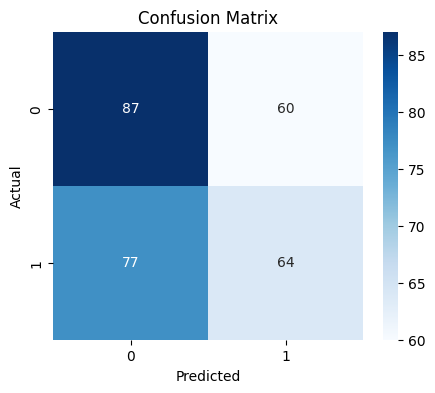

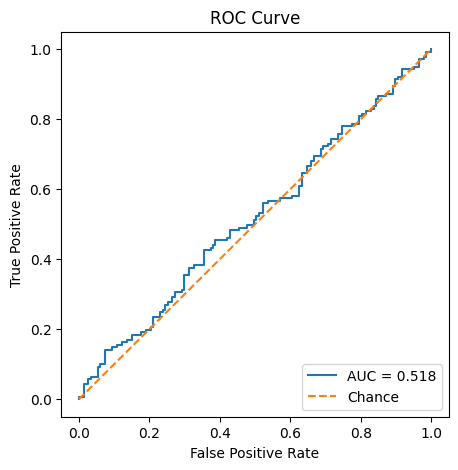

In [9]:
# Detailed Model Evaluation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

df = load_and_clean(DATA_PATH)
df = engineer_features(df)

X = df.drop(columns=['purchase_again'])
y = df['purchase_again']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
pipe = joblib.load('../models/logistic_model.pkl')
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:,1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'--', label="Chance")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.show()


In [10]:
# STEP 6: Customer Segmentation (K-Means)
def customer_segmentation(df: pd.DataFrame, max_k=10):
    feats = df[['age','ticket_price','number_of_person','revenue']]
    scaler = StandardScaler()
    Xs = scaler.fit_transform(feats)
    sil = []
    ks = list(range(2, max_k+1))
    for k in ks:
        km = KMeans(n_clusters=k, random_state=42).fit(Xs)
        sil.append(silhouette_score(Xs, km.labels_))
    best = ks[int(np.argmax(sil))]
    kmf = KMeans(n_clusters=best, random_state=42).fit(Xs)
    df['cluster'] = kmf.labels_
    joblib.dump(scaler, SCALER_PATH)


In [11]:
# MAIN EXECUTION
def main():
    df = load_and_clean(DATA_PATH)
    df = engineer_features(df)
    df.to_csv(CLEANED_PATH, index=False)
    run_eda(df)
    run_stat_tests(df)
    build_and_evaluate_model(df)
    customer_segmentation(df)
    logger.info("✅ Analysis complete.")

if __name__ == '__main__':
    main()


2025-05-19 19:03 INFO Loading data from ../data/cinema_hall_ticket_sales.csv
2025-05-19 19:03 INFO Missing values by column:
ticket_id           0
age                 0
ticket_price        0
movie_genre         0
seat_type           0
number_of_person    0
purchase_again      0
dtype: int64
/var/folders/d9/3g7dtx1d5c76jjh6sb79zbf40000gn/T/ipykernel_36029/1495652670.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df.groupby('age_group')['purchase_again'].mean()
2025-05-19 19:03 INFO HYPOTHESIS TESTING RESULTS:
2025-05-19 19:03 INFO H1 Chi2=0.94, p=0.3314
2025-05-19 19:03 INFO H2 T-test t=-0.80, p=0.4218
2025-05-19 19:03 INFO H3 ANOVA F=1.83, p=0.1209
2025-05-19 19:03 INFO Logistic Regression AUC: 0.518
2025-05-19 19:03 INFO ✅ Analysis complete.


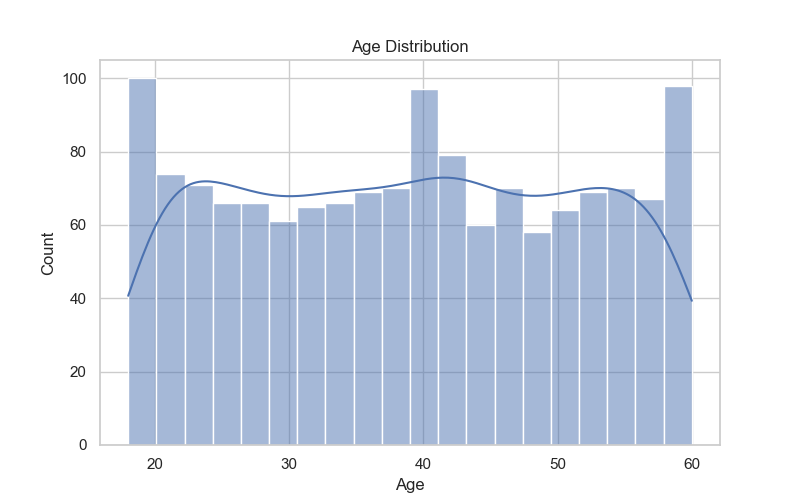

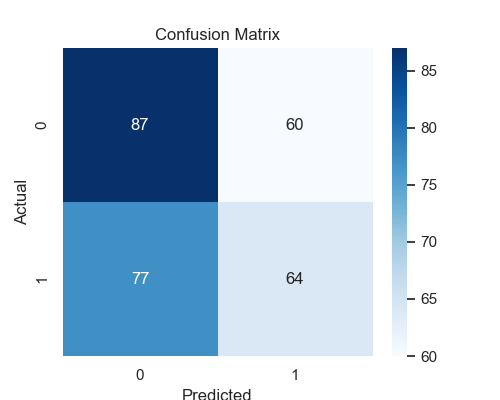

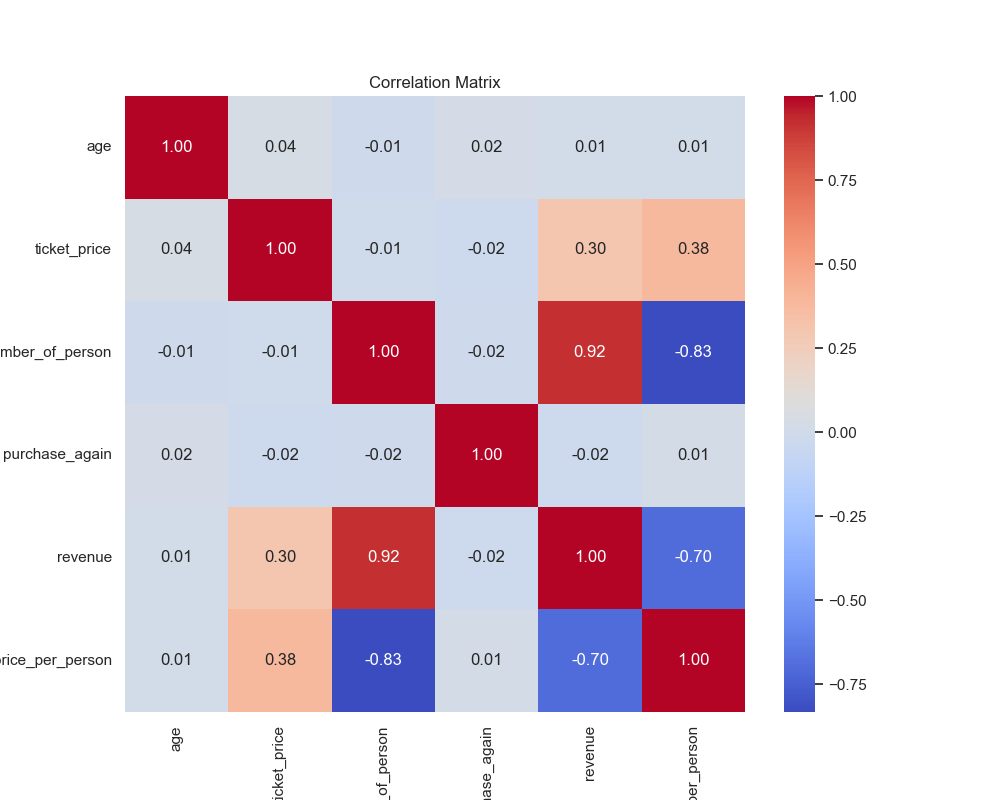

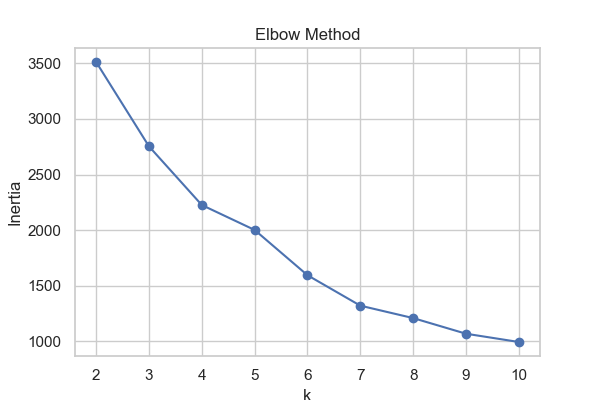

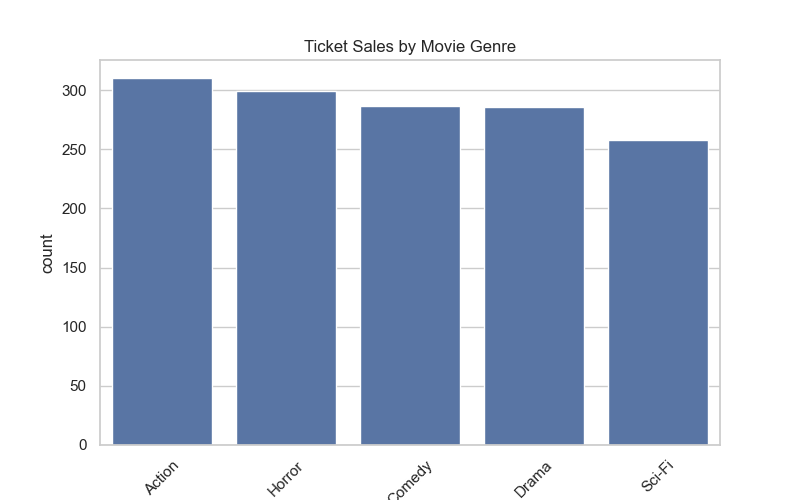

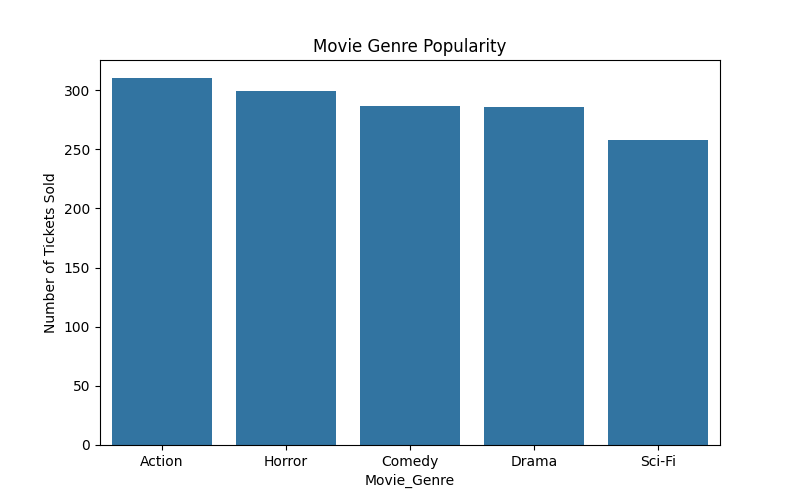

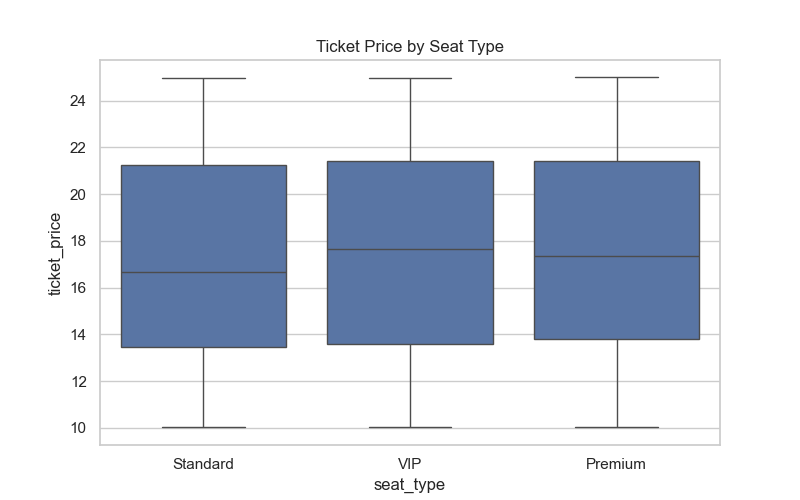

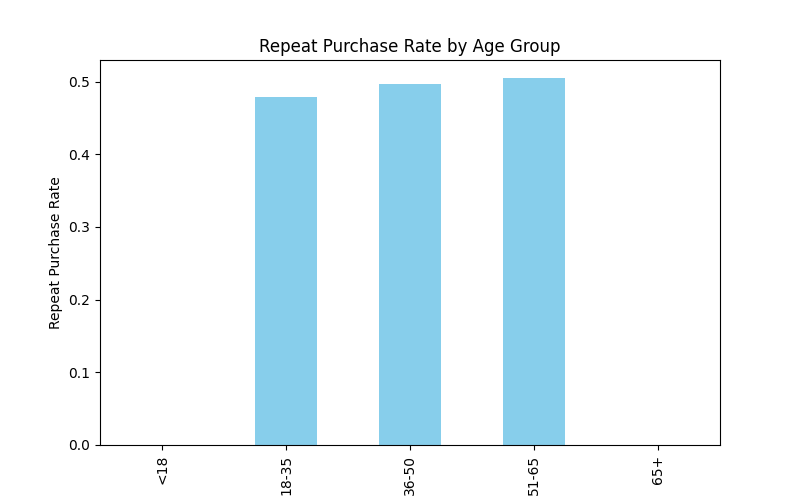

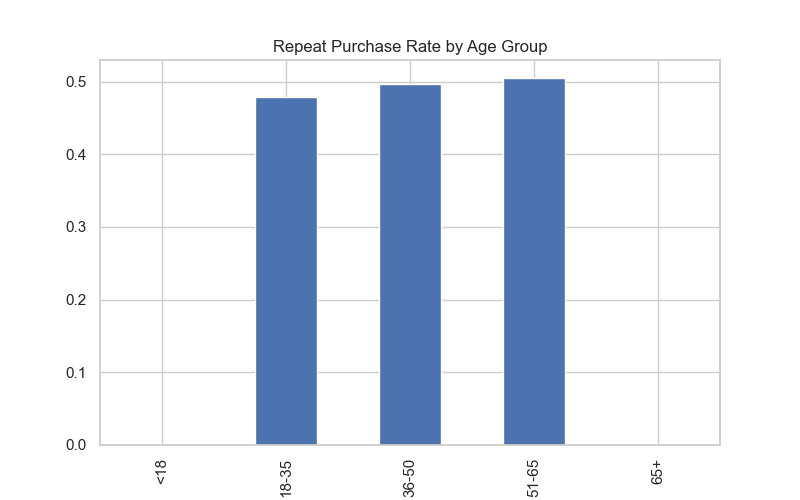

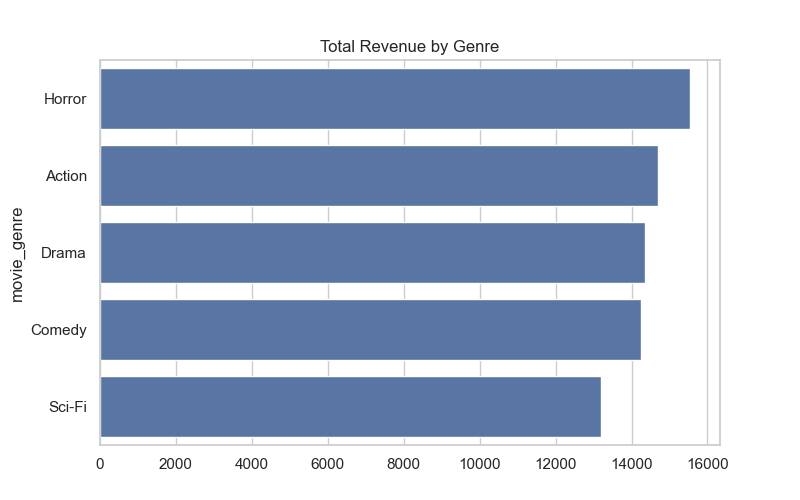

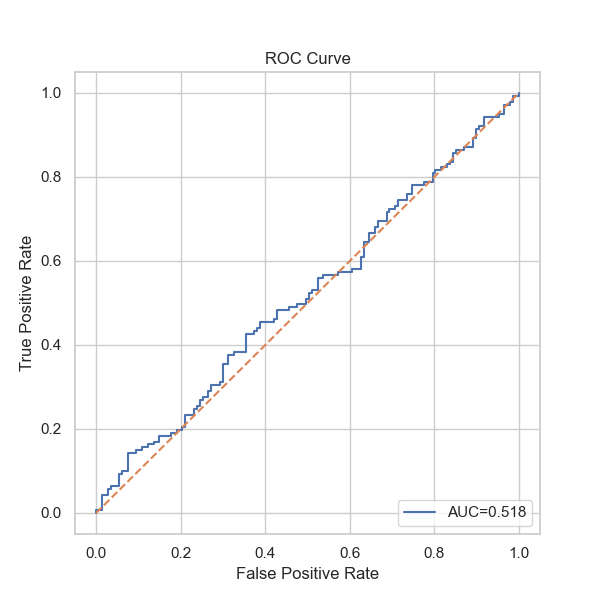

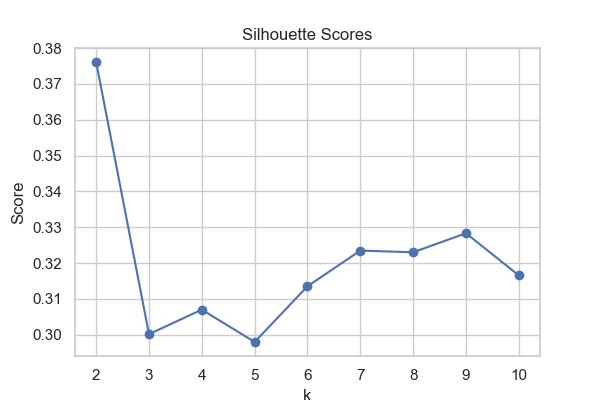

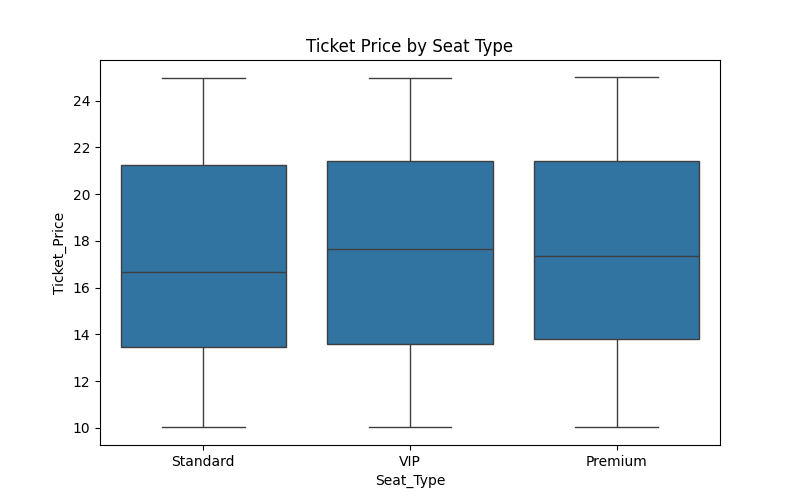

In [12]:
# Display saved visuals
from IPython.display import Image, display

visual_dir = '../visuals'
for fname in sorted(os.listdir(visual_dir)):
    if fname.endswith('.png'):
        display(Image(filename=os.path.join(visual_dir, fname)))


In [13]:
# Load & pprint scaler
import joblib
from pprint import pprint

scaler = joblib.load('../models/scaler.pkl')
pprint({
    'with_mean': scaler.with_mean,
    'with_std':  scaler.with_std,
    'mean_':      scaler.mean_.tolist(),
    'scale_':     scaler.scale_.tolist(),
    'var_':       scaler.var_.tolist(),
})


{'mean_': [38.90486111111111,
           17.38397222222222,
           2.8819444444444446,
           50.05024999999999],
 'scale_': [12.421977778323157,
            4.39555993453818,
            2.19182992984356,
            41.45068844514393],
 'var_': [154.30553192515433,
          19.320947138117283,
          4.804118441358026,
          1718.1595725763887],
 'with_mean': True,
 'with_std': True}


In [14]:
# Load the logistic regression pipeline
model = joblib.load('../models/logistic_model.pkl')
print("Model object:", model)


Model object: Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'number_of_person',
                                                   'ticket_price', 'revenue',
                                                   'price_per_person']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['seat_type', 'movie_genre',
                                                   'age_group'])])),
                ('clf', LogisticRegression(max_iter=1000))])
